In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime
import seaborn as sns
import plotly.express as px
import chart_studio.plotly as py
import plotly.graph_objects as go
import pandas as pd
import chart_studio

In [4]:
senate = pd.read_csv('Data for Finance Final Project - Senate Dataset.csv')
stocks = pd.read_csv('Data for Finance Final Project - Stock Financial Data.csv')
stock_sector = pd.read_csv('Data for Finance Final Project - Stock Sector Data.csv')
senate_stock = pd.read_csv('Data for Finance Final Project - updated senate dataset with stock info.csv')

In [5]:
senate_networth = pd.read_csv('networth_senate.csv')

In [6]:
# prepare senate networth data to scale the trades accordingly
senate_networth = senate_networth[senate_networth['Chamber'] == 'Senate']
senate_networth['senator'] = senate_networth['Name'].apply(lambda x: x.split('(')[0].strip())
senate_networth = senate_networth[senate_networth['senator'].isin(senate['senator'].unique())]
senate_networth['prc'] = pd.cut(senate_networth['Average'], bins=3, labels=[25, 50, 75])

senate_networth

Rank                        Name  Minimum Net Worth      Average  \
0       1          Mark Warner (D-Va)         80129151.0  214092575.0   
7       8  Dianne Feinstein (D-Calif)         55027069.0   87938540.0   
14     15          John Hoeven (R-ND)         19263138.0   46689569.0   
19     20         Ron Johnson (R-Wis)         14101014.0   39233507.0   
26     27    Lamar Alexander (R-Tenn)         -9491902.0   25919044.0   
27     28         David Perdue (R-Ga)         10195194.0   25822596.0   
34     35     Michael Bennet (D-Colo)          6277029.0   15706014.0   
54     55        Angus King (I-Maine)          3477125.0    9494061.0   
68     69   Sheldon Whitehouse (D-RI)          3064259.0    7443628.0   
69     70         Richard Burr (R-NC)          3426214.0    7426213.0   
78     79           Ron Wyden (D-Ore)          5370048.0    6877025.0   
92     93     Maria Cantwell (D-Wash)          1094022.0    5756508.0   
94     95            Roy Blunt (R-Mo)          2599022.0    5704510.0   
110   111          Mike Rounds (R-SD)         -1442935.0    4532031.0   
113   114        Gary Peters (D-Mich)          1750211.0    4368105.0   
120   121     Susan Collins (R-Maine)          2255087.0    4124043.0   
122   123       Jeanne Shaheen (D-NH)          -344974.0    3823005.0   
144   145         Pat Roberts (R-Kan)          1680030.0    2966514.0   
177   178       John Cornyn (R-Texas)          1074046.0    1884522.0   
181   182         Jerry Moran (R-Kan)           749079.0    1759539.0   
185   186         Tina Smith (D-Minn)         -3638944.0    1696020.0   
186   187       Patty Murray (D-Wash)           839022.0    1687010.0   
248   249          Cory Booker (D-NJ)           515006.0     807503.0   
262   263     Tammy Duckworth (D-Ill)           139063.0     697531.0   
420   421       Roger Wicker (R-Miss)          -788986.0    -180995.0   

     Maximum Net Worth Chamber             senator prc  
0          348056000.0  Senate         Mark Warner  75  
7          120850011.0  Senate    Dianne Feinstein  50  
14          74116000.0  Senate         John Hoeven  25  
19          64366000.0  Senate         Ron Johnson  25  
26          61329991.0  Senate     Lamar Alexander  25  
27          41449999.0  Senate        David Perdue  25  
34          25135000.0  Senate      Michael Bennet  25  
54          15510998.0  Senate          Angus King  25  
68          11822998.0  Senate  Sheldon Whitehouse  25  
69          11426212.0  Senate        Richard Burr  25  
78           8384003.0  Senate           Ron Wyden  25  
92          10418994.0  Senate      Maria Cantwell  25  
94           8809999.0  Senate           Roy Blunt  25  
110         10506998.0  Senate         Mike Rounds  25  
113          6985999.0  Senate         Gary Peters  25  
120          5993000.0  Senate       Susan Collins  25  
122          7990984.0  Senate      Jeanne Shaheen  25  
144          4252999.0  Senate         Pat Roberts  25  
177          2694999.0  Senate         John Cornyn  25  
181          2769999.0  Senate         Jerry Moran  25  
185          7030984.0  Senate          Tina Smith  25  
186          2534999.0  Senate        Patty Murray  25  
248          1100000.0  Senate         Cory Booker  25  
262          1255999.0  Senate     Tammy Duckworth  25  
420           426995.0  Senate        Roger Wicker  25

In [7]:
# mostly 25th percentile
senate_networth['prc'].value_counts()

25    23
50     1
75     1
Name: prc, dtype: int64

In [8]:
senate = pd.merge(senate, senate_networth[['senator', 'prc']], on='senator', how='left')

# as mostly 25th percentile fill the NAs accordingly
senate['prc'] = senate['prc'].fillna(25)

In [9]:
senate[['senator','trade_amount_min','trade_amount_max', 'prc']]

senator  trade_amount_min  trade_amount_max prc
0       Thomas Carper           15000.0           50000.0  25
1      Patrick Toomey            1000.0           15000.0  25
2         Jerry Moran            1000.0           15000.0  25
3         Jerry Moran            1000.0           15000.0  25
4      Patrick Toomey            1000.0           15000.0  25
...               ...               ...               ...  ..
8260    Thomas Carper            1000.0           15000.0  25
8261  Lamar Alexander           50000.0          100000.0  25
8262  Lamar Alexander           50000.0          100000.0  25
8263    Thomas Carper            1000.0           15000.0  25
8264  Lamar Alexander           15000.0           50000.0  25

[8265 rows x 4 columns]

In [10]:
weighted_trade_amount = []
senate_vals = senate[['senator','trade_amount_min','trade_amount_max', 'prc']].values
senate_vals

array([['Thomas Carper', 15000.0, 50000.0, 25],
       ['Patrick Toomey', 1000.0, 15000.0, 25],
       ['Jerry Moran', 1000.0, 15000.0, 25],
       ...,
       ['Lamar Alexander', 50000.0, 100000.0, 25],
       ['Thomas Carper', 1000.0, 15000.0, 25],
       ['Lamar Alexander', 15000.0, 50000.0, 25]], dtype=object)

In [11]:
np.linspace(senate_vals[0,1], senate_vals[0,2])

array([15000.        , 15714.28571429, 16428.57142857, 17142.85714286,
       17857.14285714, 18571.42857143, 19285.71428571, 20000.        ,
       20714.28571429, 21428.57142857, 22142.85714286, 22857.14285714,
       23571.42857143, 24285.71428571, 25000.        , 25714.28571429,
       26428.57142857, 27142.85714286, 27857.14285714, 28571.42857143,
       29285.71428571, 30000.        , 30714.28571429, 31428.57142857,
       32142.85714286, 32857.14285714, 33571.42857143, 34285.71428571,
       35000.        , 35714.28571429, 36428.57142857, 37142.85714286,
       37857.14285714, 38571.42857143, 39285.71428571, 40000.        ,
       40714.28571429, 41428.57142857, 42142.85714286, 42857.14285714,
       43571.42857143, 44285.71428571, 45000.        , 45714.28571429,
       46428.57142857, 47142.85714286, 47857.14285714, 48571.42857143,
       49285.71428571, 50000.        ])

In [12]:
# account for the trading amount according to the networth
for i in range(senate_vals.shape[0]):
    weighted_trade_amount.append(np.percentile(np.linspace(senate_vals[i,1], 
                                                           senate_vals[i,2]),
                                               senate_vals[i,3]))

In [13]:
senate['amount_weighted'] = weighted_trade_amount

In [14]:
senate.head()

senator  party  sex trade_date   owner ticker      type  \
0   Thomas Carper    1.0    1  29Jan2021  Spouse  XCAPX  Purchase   
1  Patrick Toomey    0.0    1  28Jan2021   Child    GME      Sale   
2     Jerry Moran    0.0    1  27Jan2021  Spouse   COST      Sale   
3     Jerry Moran    0.0    1  27Jan2021    Self   COST      Sale   
4  Patrick Toomey    0.0    1  27Jan2021   Child   SHOP      Sale   

   trade_amount_max  trade_amount_min  buy_one_year_change  \
0           50000.0           15000.0                  NaN   
1           15000.0            1000.0                  NaN   
2           15000.0            1000.0                  NaN   
3           15000.0            1000.0                  NaN   
4           15000.0            1000.0                  NaN   

   one_mo_vtsax_change  one_year_vtsax_change  buy_compare_one_year  \
0             0.031875                    NaN                   NaN   
1             0.016324                    NaN                   NaN   
2             0.054616                    NaN                   NaN   
3             0.054616                    NaN                   NaN   
4             0.054616                    NaN                   NaN   

   one_month_sell  one_month_sell_compare  weight prc  amount_weighted  
0             NaN                     NaN    4.06  25          23750.0  
1       -0.438378               -0.454702    1.00  25           4500.0  
2       -0.044025               -0.098641    1.00  25           4500.0  
3       -0.044025               -0.098641    1.00  25           4500.0  
4        0.191442                0.136826    1.00  25           4500.0

## Data Analysis

In [15]:
senate = senate[['senator', 'trade_date', 'party', 'owner', 'ticker', 'type',
                 'amount_weighted', 'trade_amount_max', 'trade_amount_min']]

senate['trade_date'] = senate['trade_date'].apply(lambda x: datetime.strptime(x, '%d%b%Y'))

senate = senate.dropna()
senate['type'] = senate['type'].map({'Purchase': 'buy', 'Sale': 'sell'})
senate = senate.set_index('trade_date')
senate = senate.sort_index(ascending=True)

senate['amount_avg'] = (senate['trade_amount_max'] + senate['trade_amount_min'])/2

senate['party'] = np.where(senate['party'] == 1, 'Dem', 'Rep')

In [16]:
senate

senator party   owner ticker  type  amount_weighted  \
trade_date                                                                
2012-06-14  Lamar Alexander   Rep  Spouse     --  sell          23750.0   
2012-09-13    Thomas Carper   Dem  Spouse     DD   buy           4500.0   
2012-10-24  Lamar Alexander   Rep  Spouse     --   buy          62500.0   
2012-11-01  Lamar Alexander   Rep  Spouse     --  sell          62500.0   
2012-12-17    Thomas Carper   Dem  Spouse     DD   buy           4500.0   
...                     ...   ...     ...    ...   ...              ...   
2021-01-27   Patrick Toomey   Rep   Child   SHOP  sell           4500.0   
2021-01-27      Jerry Moran   Rep    Self   COST  sell           4500.0   
2021-01-27      Jerry Moran   Rep  Spouse   COST  sell           4500.0   
2021-01-28   Patrick Toomey   Rep   Child    GME  sell           4500.0   
2021-01-29    Thomas Carper   Dem  Spouse  XCAPX   buy          23750.0   

            trade_amount_max  trade_amount_min  amount_avg  
trade_date                                                  
2012-06-14           50000.0           15000.0     32500.0  
2012-09-13           15000.0            1000.0      8000.0  
2012-10-24          100000.0           50000.0     75000.0  
2012-11-01          100000.0           50000.0     75000.0  
2012-12-17           15000.0            1000.0      8000.0  
...                      ...               ...         ...  
2021-01-27           15000.0            1000.0      8000.0  
2021-01-27           15000.0            1000.0      8000.0  
2021-01-27           15000.0            1000.0      8000.0  
2021-01-28           15000.0            1000.0      8000.0  
2021-01-29           50000.0           15000.0     32500.0  

[7789 rows x 9 columns]

In [17]:
# trades by senator
num_trades_sen = pd.DataFrame(senate.groupby(['senator', 
                                              'party']).agg({'type':'count', 
                                                             'amount_weighted':'sum'})).reset_index().rename(columns={'type':'Total Number of Transactions', 
                                                                                                                      'amount_weighted':'Total Weighted Amount of Transactions'})
# amount_avg changed into amount_weighted

In [18]:
# sns.scatterplot(data=num_trades_sen, 
#                 x="Total Number of Transactions", 
#                 y="Total Average of Transactions", 
#                 hue="party")

In [19]:
num_trades_sen

senator party  Total Number of Transactions  \
0   A. MitchellMcconnell   Rep                            18   
1        Benjamin Cardin   Dem                            15   
2        Chris VanHollen   Rep                             6   
3      Christopher Coons   Dem                            23   
4            Cory Booker   Dem                            13   
5        Daniel Sullivan   Rep                            26   
6           David Perdue   Rep                          2561   
7        Diane Feinstein   Dem                             2   
8            Gary Peters   Dem                           134   
9          Jacklyn Rosen   Dem                             5   
10          James Inhofe   Rep                           219   
11        Jeanne Shaheen   Dem                             3   
12           Jerry Moran   Rep                           136   
13         John Barrasso   Rep                             1   
14           John Cornyn   Dem                             2   
15           John Hoeven   Rep                           206   
16          John Kennedy   Rep                             2   
17             John Reed   Dem                           236   
18     Joseph ManchinIii   Dem                            12   
19        Kelly Loeffler   Rep                           272   
20       Lamar Alexander   Rep                            59   
21        Maria Cantwell   Rep                             5   
22           Mark Warner   Dem                            42   
23        Michael Bennet   Dem                             7   
24         Michael Crapo   Dem                             1   
25          Michael Enzi   Dem                             5   
26           Mike Rounds   Rep                             9   
27           Pat Roberts   Rep                           448   
28        Patrick Toomey   Rep                           188   
29          Patty Murray   Rep                           159   
30           Rafael Cruz   Rep                            10   
31          Richard Burr   Rep                            38   
32            Rick Scott   Rep                           146   
33          Robert Casey   Dem                             1   
34        Robert Portman   Rep                             9   
35          Roger Wicker   Rep                             8   
36           Ron Johnson   Rep                             2   
37             Ron Wyden   Dem                           211   
38             Roy Blunt   Rep                             6   
39    Sheldon Whitehouse   Dem                           623   
40        Shelley Capito   Rep                           344   
41          Steve Daines   Rep                             1   
42         Susan Collins   Rep                           378   
43       Tammy Duckworth   Dem                            19   
44         Thomas Carper   Dem                           890   
45         Thomas Tillis   Rep                            99   
46          Thomas Udall   Dem                             2   
47         Timothy Kaine   Dem                             3   
48            Tina Smith   Dem                            23   
49       William Cassidy   Rep                           161   

    Total Weighted Amount of Transactions  
0                                832250.0  
1                                299000.0  
2                                 65500.0  
3                               2970000.0  
4                                174250.0  
5                                908000.0  
6                              54147500.0  
7                               2625000.0  
8                               1065000.0  
9                                 41750.0  
10                             40844750.0  
11                               165750.0  
12                               746750.0  
13                                62500.0  
14                                47500.0  
15                             28169250.0  
16  

In [20]:
chart_studio.tools.set_credentials_file(username='hargrigory', api_key='967KVMJTMHtugWcN6Oo2')

In [21]:
fig = px.scatter(num_trades_sen, x='Total Number of Transactions', y='Total Weighted Amount of Transactions', 
                 color='party',
                 size = 'Total Weighted Amount of Transactions',
                 width=700, height=500, hover_data=['senator'],
                 title="By Senator")
fig.show()
# py.iplot(fig, filename='pandas-multiple-scatter')

In [22]:
fig = px.histogram(num_trades_sen, 
                   x="Total Weighted Amount of Transactions", 
                   y="Total Number of Transactions", 
                   color="party",
                   marginal="box", # or violin, rug
                   nbins=50,
                   hover_data=num_trades_sen.columns)
fig.show()
# py.iplot(fig, filename='dist-plot')

In [23]:
senate.groupby(['senator', 'party']).apply(len).sort_values(ascending=False)

senator               party
David Perdue          Rep      2561
Thomas Carper         Dem       890
Sheldon Whitehouse    Dem       623
Pat Roberts           Rep       448
Susan Collins         Rep       378
Shelley Capito        Rep       344
Kelly Loeffler        Rep       272
John Reed             Dem       236
James Inhofe          Rep       219
Ron Wyden             Dem       211
John Hoeven           Rep       206
Patrick Toomey        Rep       188
William Cassidy       Rep       161
Patty Murray          Rep       159
Rick Scott            Rep       146
Jerry Moran           Rep       136
Gary Peters           Dem       134
Thomas Tillis         Rep        99
Lamar Alexander       Rep        59
Mark Warner           Dem        42
Richard Burr          Rep        38
Daniel Sullivan       Rep        26
Christopher Coons     Dem        23
Tina Smith            Dem        23
Tammy Duckworth       Dem        19
A. MitchellMcconnell  Rep        18
Benjamin Cardin       Dem        15


In [24]:
# -- wealthiest current
# Rick Scott
# Mark Warner

# -- most active
# David Perdue            
# Thomas Carper            
# Sheldon Whitehouse

In [25]:
wealthiest = ['Rick Scott', 'Mark Warner']
active = ['David Perdue', 'Thomas Carper', 'Sheldon Whitehouse']

names = ['Rick Scott', 'Mark Warner', 'David Perdue', 'Thomas Carper', 'Sheldon Whitehouse']

In [26]:
wealth_sen = senate[senate['senator'].isin(wealthiest)].reset_index(drop=True)
active_sen = senate[senate['senator'].isin(active)].reset_index(drop=True)

In [27]:
# rick = senate[senate['senator'] == names[0]]

# rick['type'] = rick['type'].map({'Purchase': 'buy', 'Sale': 'sell'})

# rick = rick.set_index('trade_date')

# rick = rick.sort_index(ascending=True)

In [28]:
# rick[rick['type'] == 'buy'].index
# rick[rick['type'] == 'sell'].index

In [29]:
def getYahooData(ticker, start, end, interval='1d'):
    # Download the ticker prices
    data = yf.download(ticker, start=start, end=end, interval=interval) 
    # Set the index to a datetime type
    data.index = pd.to_datetime(data.index)
    
    return data

In [30]:
def plotSenTrades(ticker_data, senator, name):
    senator = senator[senator['senator'] == name]
    start = min(senator.index)
    end = max(senator.index)
    
    ticker_data = ticker_data[start:end]
    
#     ticker_data = data[data['senator'] == name]
    plt.plot(senator[senator['type'] == 'buy'].index,
         ticker_data.loc[senator[senator['type'] == 'buy'].index,:]['Adj Close'],  
         '^', markersize=10, color='g')
    plt.plot(senator[senator['type'] == 'sell'].index,
             ticker_data.loc[senator[senator['type'] == 'sell'].index,:]['Adj Close'], 
             'v', markersize=10, color='r')
    plt.title(name)
    ticker_data['Adj Close'].plot(figsize=(20,8))

In [31]:
vtsax_data = getYahooData("VTSAX", min(senate.index), max(senate.index), interval='1d')
spy_data = getYahooData("^GSPC", min(senate.index), max(senate.index), interval='1d')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


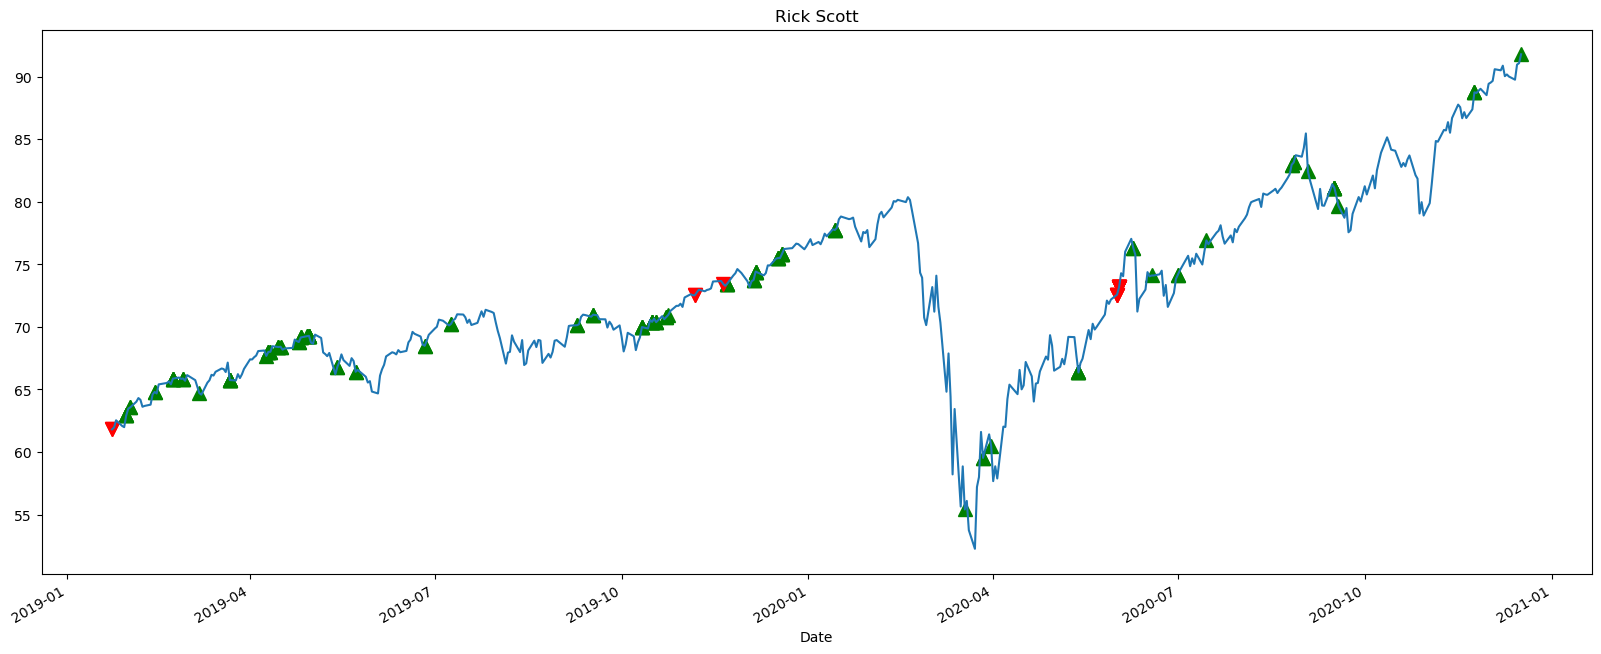

In [32]:
plotSenTrades(vtsax_data, senate, wealthiest[0])

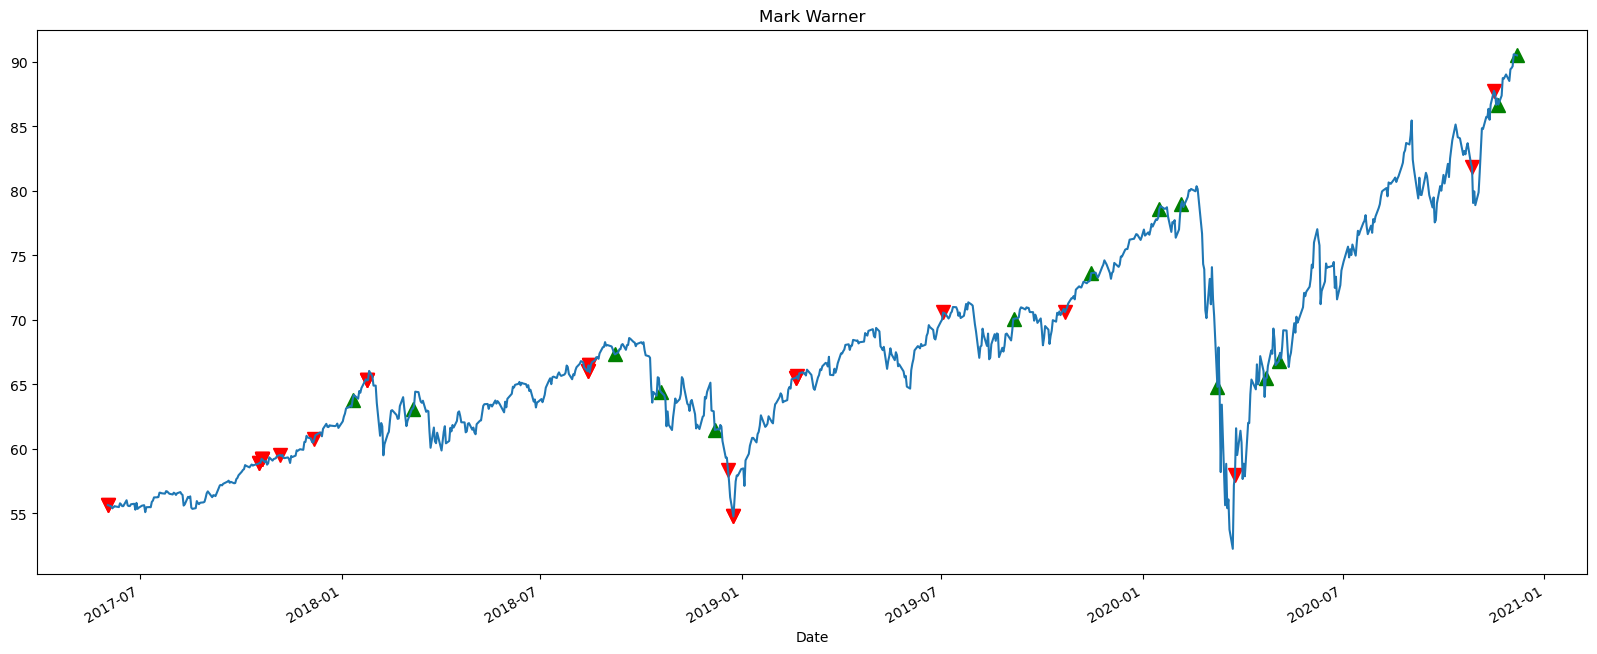

In [33]:
plotSenTrades(vtsax_data, senate, wealthiest[1])

In [34]:
ticker = senate.reset_index()

ticker = ticker[ticker['ticker'] != '--']

ticker = pd.DataFrame(ticker.groupby(['trade_date', 'ticker', 'type'])['senator'].count()).reset_index()

In [35]:
top50_stocks = pd.DataFrame(ticker.groupby(['ticker'])['senator'].count()).reset_index().sort_values('senator').iloc[-50:]

top50_stocks = top50_stocks.rename(columns={'senator':'Number of transactions'})

<AxesSubplot:xlabel='ticker'>

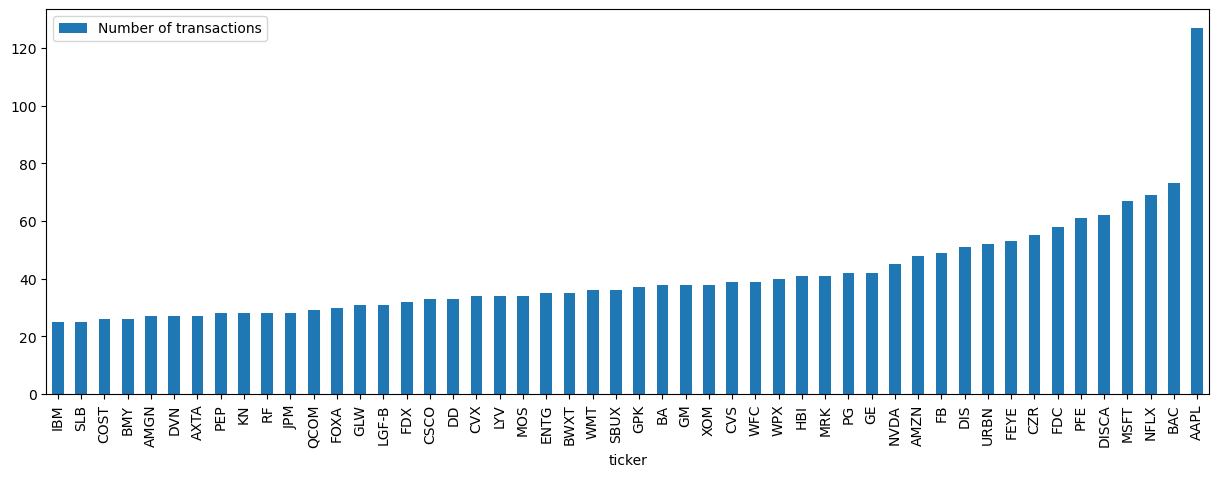

In [36]:
top50_stocks.plot.bar(x='ticker', y='Number of transactions', figsize=(15,5))

In [37]:
ticker = ticker.sort_values('trade_date').set_index('trade_date')

In [38]:
def plotTickerTrades(market_data, ticker, name):
    ticker = ticker[ticker['ticker'] == name]
    start = min(ticker.index)
    end = max(ticker.index)
    
    market_data = market_data[start:end]
    
#     ticker_data = data[data['senator'] == name]
    plt.plot(ticker[ticker['type'] == 'buy'].index,
         market_data.loc[ticker[ticker['type'] == 'buy'].index,:]['Adj Close'],  
         '^', markersize=10, color='g')
    plt.plot(ticker[ticker['type'] == 'sell'].index,
             market_data.loc[ticker[ticker['type'] == 'sell'].index,:]['Adj Close'], 
             'v', markersize=10, color='r')
    plt.title(name)
    market_data['Adj Close'].plot(figsize=(20,8))

In [39]:
aapl_data = getYahooData("AAPL", min(ticker.index), max(ticker.index), interval='1d')
nflx_data = getYahooData("NFLX", min(senate.index), max(senate.index), interval='1d')
bac_data = getYahooData("BAC", min(senate.index), max(senate.index), interval='1d')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


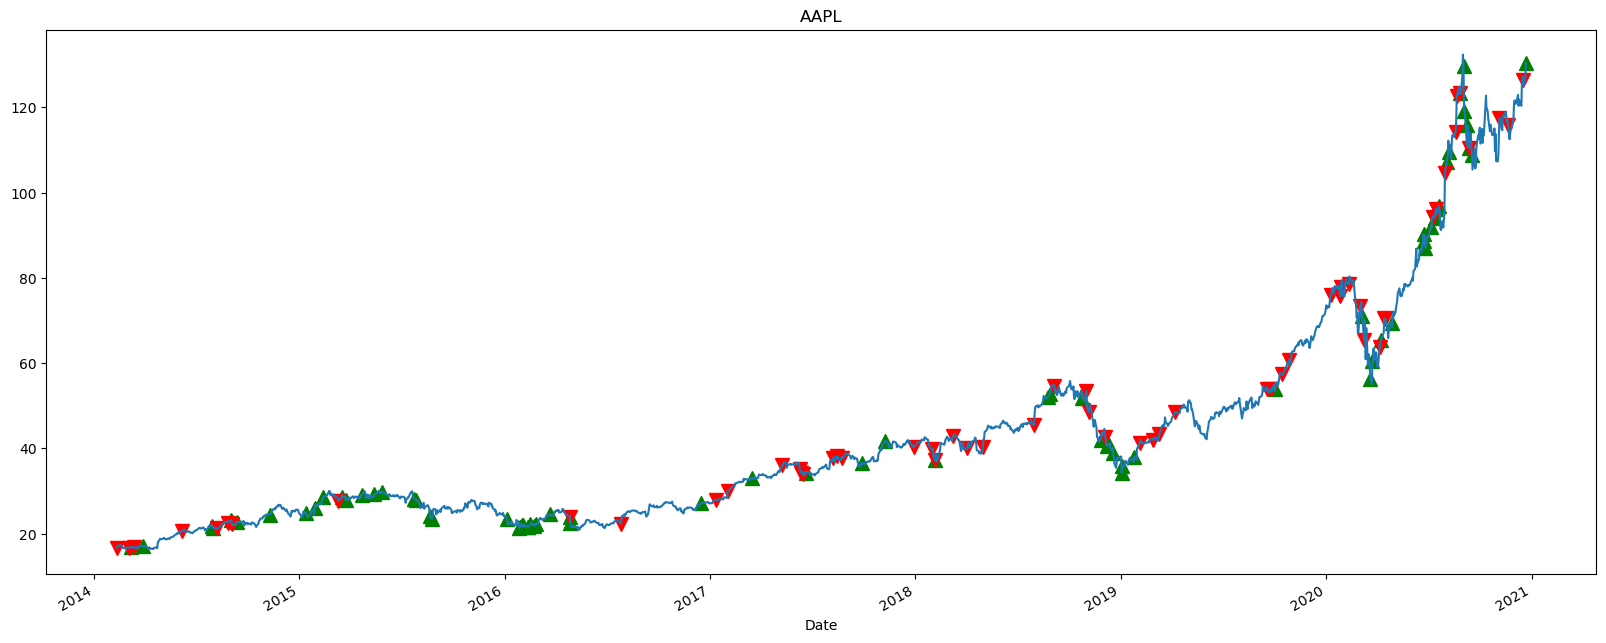

In [40]:
plotTickerTrades(aapl_data, ticker, 'AAPL')

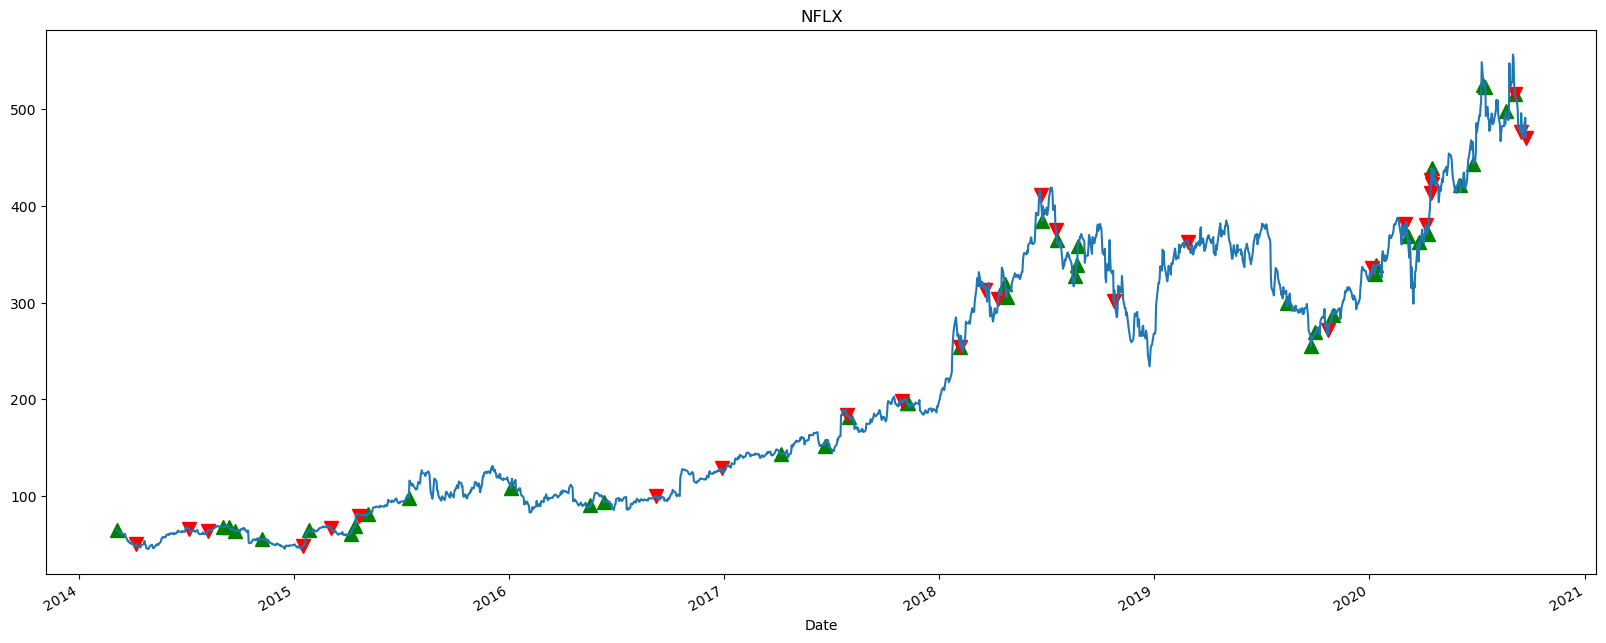

In [41]:
plotTickerTrades(nflx_data, ticker, 'NFLX')

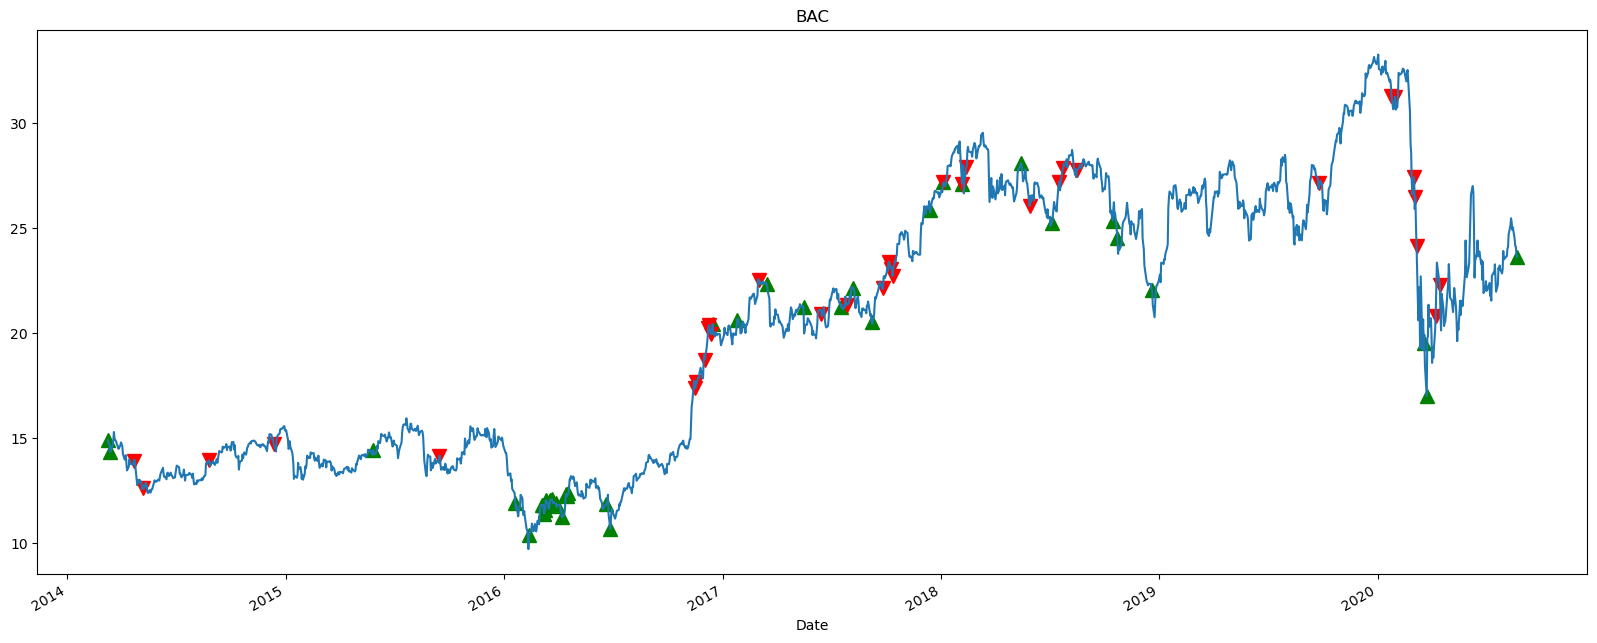

In [42]:
plotTickerTrades(bac_data, ticker, 'BAC')

## NMF on ETFs and sectors

In [2]:
from sklearn.decomposition import NMF

In [44]:
spy_data = getYahooData("SPY", min(ticker.index), max(ticker.index), interval='1d')
vti_data = getYahooData("VTI", min(ticker.index), max(ticker.index), interval='1d')
qqq_data = getYahooData("QQQ", min(ticker.index), max(ticker.index), interval='1d')
vtv_data = getYahooData("VTV", min(ticker.index), max(ticker.index), interval='1d')
vug_data = getYahooData("VUG", min(ticker.index), max(ticker.index), interval='1d')
schd_data = getYahooData("SCHD", min(ticker.index), max(ticker.index), interval='1d')
dia_data = getYahooData("DIA", min(ticker.index), max(ticker.index), interval='1d')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [45]:
# sectors
xlv_data = getYahooData("XLV", min(ticker.index), max(ticker.index), interval='1d') # health
vgt_data = getYahooData("VGT", min(ticker.index), max(ticker.index), interval='1d') # tech
xlf_data = getYahooData("XLF", min(ticker.index), max(ticker.index), interval='1d') # finance

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [46]:
etfs = pd.concat([spy_data[['Adj Close']], 
                  vti_data[['Adj Close']], 
                  qqq_data[['Adj Close']], 
                  vtv_data[['Adj Close']],
                  vug_data[['Adj Close']], 
                  schd_data[['Adj Close']], 
                  dia_data[['Adj Close']]],
                 axis=1, 
                 keys=['SPY', 'VTI', 'QQQ', 'VTV', 'VUG', 'SCHD', 'DIA'])

In [47]:
sectors = pd.concat([xlv_data[['Adj Close']], 
                       vgt_data[['Adj Close']], 
                       xlf_data[['Adj Close']]],
                      axis=1, 
                      keys=['XLV', 'VGT', 'XLF'])

In [48]:
model_etfs = NMF(n_components=3, init='random', beta_loss='frobenius', random_state=0, max_iter=10000)
W_etfs = model_etfs.fit_transform(etfs.fillna(0).values)
H_etfs = model_etfs.components_

In [49]:
# model_etfs_sparse = NMF(n_components=3, init='nndsvd', beta_loss='frobenius', random_state=0, max_iter=10000)
# W_etfs_sparse = model_etfs_sparse.fit_transform(etfs.fillna(0).values)
# H_etfs_sparse = model_etfs_sparse.components_

In [50]:
df_W = pd.DataFrame(W_etfs, index=etfs.index, columns=['C1', 'C2', 'C3'])

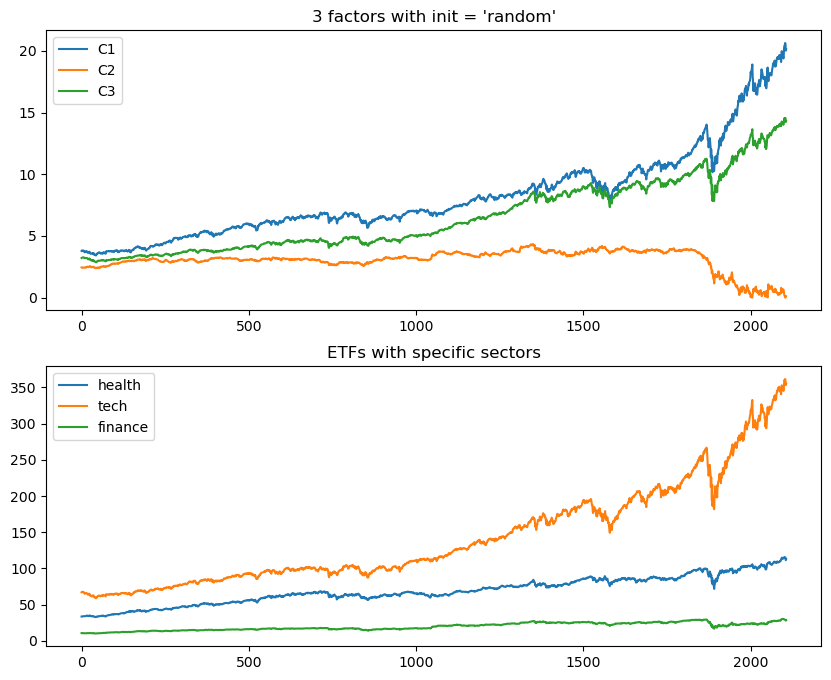

In [51]:
plt.figure(figsize=(10,8))
plt.subplot(2, 1, 1)

plt.title("3 factors with init = 'random'")
plt.plot(W_etfs[:,0], label='C1')
plt.plot(W_etfs[:,1], label='C2')
plt.plot(W_etfs[:,2], label='C3')
plt.legend()

plt.subplot(2, 1, 2)

plt.title("ETFs with specific sectors")
plt.plot(sectors.values[:,0], label='health')
plt.plot(sectors.values[:,1], label='tech')
plt.plot(sectors.values[:,2], label='finance')
plt.legend()

In [52]:
senator = senate[senate['senator'] == wealthiest[0]]

<AxesSubplot:xlabel='Date'>

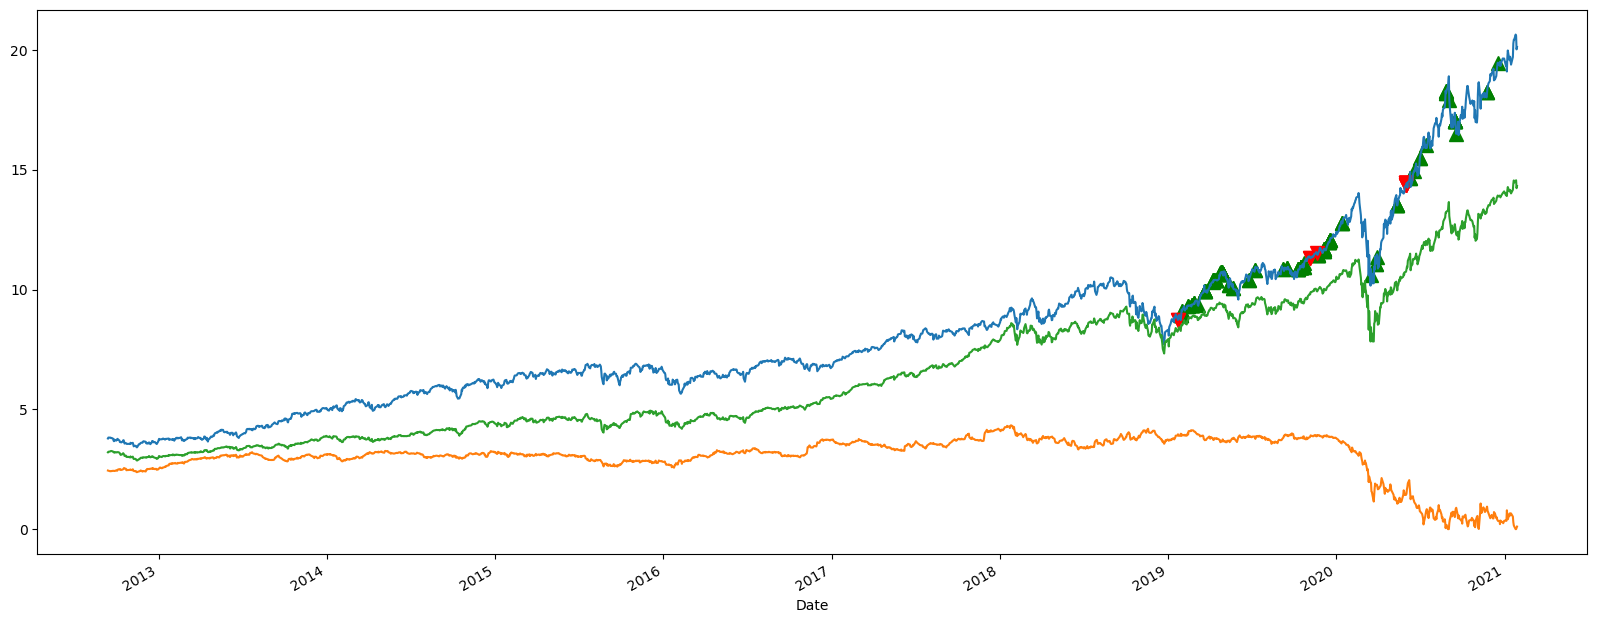

In [53]:
# senator by and sell with components on ETFs
plt.plot(senator[senator['type'] == 'buy'].index,
         df_W.loc[senator[senator['type'] == 'buy'].index,:]['C1'],  
         '^', markersize=10, color='g')
plt.plot(senator[senator['type'] == 'sell'].index,
         df_W.loc[senator[senator['type'] == 'sell'].index,:]['C1'], 
         'v', markersize=10, color='r')
df_W['C1'].plot(figsize=(20,8))
df_W['C2'].plot(figsize=(20,8))
df_W['C3'].plot(figsize=(20,8))

In [54]:
tickers = senate[senate['ticker'] != '--']['ticker'].unique()

In [55]:
senate['ticker'] = np.where(senate['ticker']=='FB', 'META', senate['ticker'])

In [56]:
senate.groupby('senator')['ticker'].nunique().sort_values()

senator
Michael Crapo             1
John Cornyn               1
John Barrasso             1
Mike Rounds               1
Jeanne Shaheen            1
Maria Cantwell            1
Robert Casey              1
Robert Portman            1
Rick Scott                1
Ron Johnson               1
Steve Daines              1
Diane Feinstein           1
Lamar Alexander           1
Thomas Udall              2
Michael Enzi              2
John Kennedy              2
Joseph ManchinIii         2
Roger Wicker              3
Roy Blunt                 3
Timothy Kaine             3
Michael Bennet            3
A. MitchellMcconnell      4
Benjamin Cardin           4
Christopher Coons         4
Jacklyn Rosen             5
Mark Warner               6
Chris VanHollen           6
Rafael Cruz               6
Tina Smith               10
Cory Booker              10
Daniel Sullivan          13
Tammy Duckworth          17
Richard Burr             21
Gary Peters              35
Jerry Moran              39
Ron Wyden   

## NMF on senate stocks

In [57]:
# !pip install yahooquery

In [58]:
from yahooquery import Ticker

In [59]:
agg_senate_stocks = pd.read_csv('aggregate_stocks_prices_nnmf.csv')

In [60]:
agg_senate_stocks.tail()

date           A    AAL         AAP        AAPL        ABBV  \
13317  2022-12-05  115.724380  15.49  205.254501  142.362244  151.320419   
13318  2022-12-07  119.033989  14.77  182.218262  145.657669  149.525650   
13319  2022-12-08  133.319275  15.25  200.743393  172.100006  141.163605   
13320  2022-12-09  139.628342  14.47  179.889008  163.429993  140.807236   
13321  2022-12-10  125.690002  12.70  169.320007  138.339996  138.569992   

              ABC        ABMD         ABT         ACN  ...         WY  \
13317  150.680908  234.350006  106.987404  278.972717  ...  37.841824   
13318  140.941238  256.260010  107.314400  271.492706  ...  34.427628   
13319  150.500000  293.589996  110.956467  319.021332  ...  36.695614   
13320  147.710007  279.160004  108.776749  293.952820  ...  34.560001   
13321  138.940002  242.770004   99.610001  250.070007  ...  29.389999   

            WYNN        XEL    XLEFF        XOM         XYL         YUM  \
13317  58.560001  72.550545  0.18683  85.469559   82.216026  109.428505   
13318  54.730000  69.048271  0.19230  83.686874   76.527847  115.264832   
13319  68.739998  75.466278  0.17937  94.000000  103.040489  117.583466   
13320  64.510002  76.906860  0.17800  97.610001   97.599998  117.260002   
13321  58.709999  57.939999  0.16500  98.430000   87.220001  105.540001   

              ZBH       ZION         ZTS  
13317  112.593025  52.740700  162.781265  
13318  102.800041  49.851093  173.491608  
13319  116.958374  57.815353  175.669998  
13320  119.003792  58.619999  166.350006  
13321  107.059998  48.439999  145.860001  

[5 rows x 411 columns]

In [61]:
nasdaq = pd.read_csv('nasdaq_screener_1669854569804.csv')['Symbol']
nyse = pd.read_csv('nasdaq_screener_1669854659250.csv')['Symbol']

In [62]:
symbols = nasdaq.append(nyse, ignore_index=True).unique()

/var/folders/6f/dgvrwwq158b46jqfnftpff2r0000gn/T/ipykernel_20190/2018917281.py:1: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [63]:
download = [i for i in tickers if i in symbols]

download = download + ['META']

delisted = [i for i in tickers if i not in symbols]

In [64]:
# Initialize Ticker
tickers_download = Ticker(download, asynchronous=True, retry=20, status_forcelist=[404, 429, 500, 502, 503, 504],
                 period='max')

In [65]:
%%time
df = tickers_download.history(period = 'max')

CPU times: user 15.1 s, sys: 1.44 s, total: 16.5 s
Wall time: 37.6 s


In [66]:
# with 3 indices
df

open        high      volume       close         low  \
symbol date                                                                     
DD     1972-06-01    0.000000    7.294257     74617.0    7.274490    7.254722   
       1972-06-02    7.294257    7.393096    227645.0    7.353560    7.294257   
       1972-06-05    7.353560    7.363444     96117.0    7.333793    7.333793   
       1972-06-06    7.333793    7.343677     77146.0    7.314025    7.294257   
       1972-06-07    7.284374    7.284374    121411.0    7.185535    7.185535   
...                       ...         ...         ...         ...         ...   
META   2022-12-05  121.750000  124.669998  35474900.0  122.430000  121.349998   
       2022-12-06  119.910004  120.550003  43689200.0  114.120003  113.739998   
       2022-12-07  113.760002  115.879997  29461100.0  113.930000  112.879997   
       2022-12-08  116.389999  117.339996  30619400.0  115.330002  114.589996   
       2022-12-09  115.300003  117.540001  23966159.0  115.900002  113.879997   

                     adjclose  dividends  splits  
symbol date                                       
DD     1972-06-01    1.124302        0.0     0.0  
       1972-06-02    1.136523        0.0     0.0  
       1972-06-05    1.133468        0.0     0.0  
       1972-06-06    1.130412        0.0     0.0  
       1972-06-07    1.110554        0.0     0.0  
...                       ...        ...     ...  
META   2022-12-05  122.430000        0.0     0.0  
       2022-12-06  114.120003        0.0     0.0  
       2022-12-07  113.930000        0.0     0.0  
       2022-12-08  115.330002        0.0     0.0  
       2022-12-09  115.900002        0.0     0.0  

[4415026 rows x 8 columns]

In [67]:
df = df.reset_index()[['symbol', 'date', 'adjclose']]

In [68]:
df = df.pivot(index='date', columns='symbol', values='adjclose')
df = df.loc[min(senate.index):max(senate.index)]

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexes/base.py:3629: FutureWarning:

Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:1541: FutureWarning:

Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.



In [69]:
df.tail()

symbol             AA        AAL        AAN       AAON        AAPL        AAT  \
date                                                                            
2021-01-25  19.156027  15.430000  20.153290  72.436684  141.224701  26.598875   
2021-01-26  18.383448  15.530000  18.638659  72.861610  141.461853  26.673254   
2021-01-27  18.482494  16.559999  17.374859  74.699699  140.374893  26.143322   
2021-01-28  18.324018  18.100000  16.844255  73.158073  135.463852  26.496609   
2021-01-29  17.828773  17.170000  16.342594  73.128433  130.394714  25.687765   

symbol            ABB        ABBV         ABT        ACA  ...         WW  \
date                                                      ...              
2021-01-25  28.507675  102.675377  111.556915  60.989021  ...  24.969999   
2021-01-26  28.915064  101.095757  111.566650  59.896206  ...  24.799999   
2021-01-27  28.251875   95.511330  111.138771  56.945602  ...  24.870001   
2021-01-28  28.564520   96.830765  117.070580  57.064816  ...  26.639999   
2021-01-29  27.958176   95.223274  120.182343  55.425591  ...  26.559999   

symbol             WY        XEL        XOM        XPO         YUM       YUMC  \
date                                                                            
2021-01-25  30.672638  63.359425  42.497265  41.329548  101.572311  57.322258   
2021-01-26  30.343018  62.702007  41.563953  41.153160  102.614464  58.274841   
2021-01-27  29.482355  60.805992  41.092762  39.271713   98.445816  57.027645   
2021-01-28  30.233149  60.634487  41.736115  39.659073   98.937958  55.996494   
2021-01-29  28.557600  60.967968  40.630646  38.185734   97.934387  55.692047   

symbol             ZBH          ZM         ZTS  
date                                            
2021-01-25  152.691071  391.829987  159.534058  
2021-01-26  151.646347  374.390015  157.922302  
2021-01-27  146.259857  370.739990  151.435715  
2021-01-28  150.505798  378.589996  154.777908  
2021-01-29  147.285385  372.070007  152.523422  

[5 rows x 634 columns]

In [70]:
# # check NAs
# df[df.isna().any(axis=1)]

In [71]:
model_sen = NMF(n_components=3, init='random', beta_loss='frobenius', random_state=0, max_iter=10000)
W_sen = model_sen.fit_transform(df.fillna(0).values)
H_sen = model_sen.components_

In [72]:
# nndsvd

In [73]:
# nndsvda

In [74]:
wealthiest[1]

'Mark Warner'

In [75]:
senator = senate[senate['senator'] == wealthiest[1]]

In [76]:
df_W_sen = pd.DataFrame(W_sen, index=df.index, columns=['C1', 'C2', 'C3'])

<AxesSubplot:xlabel='date'>

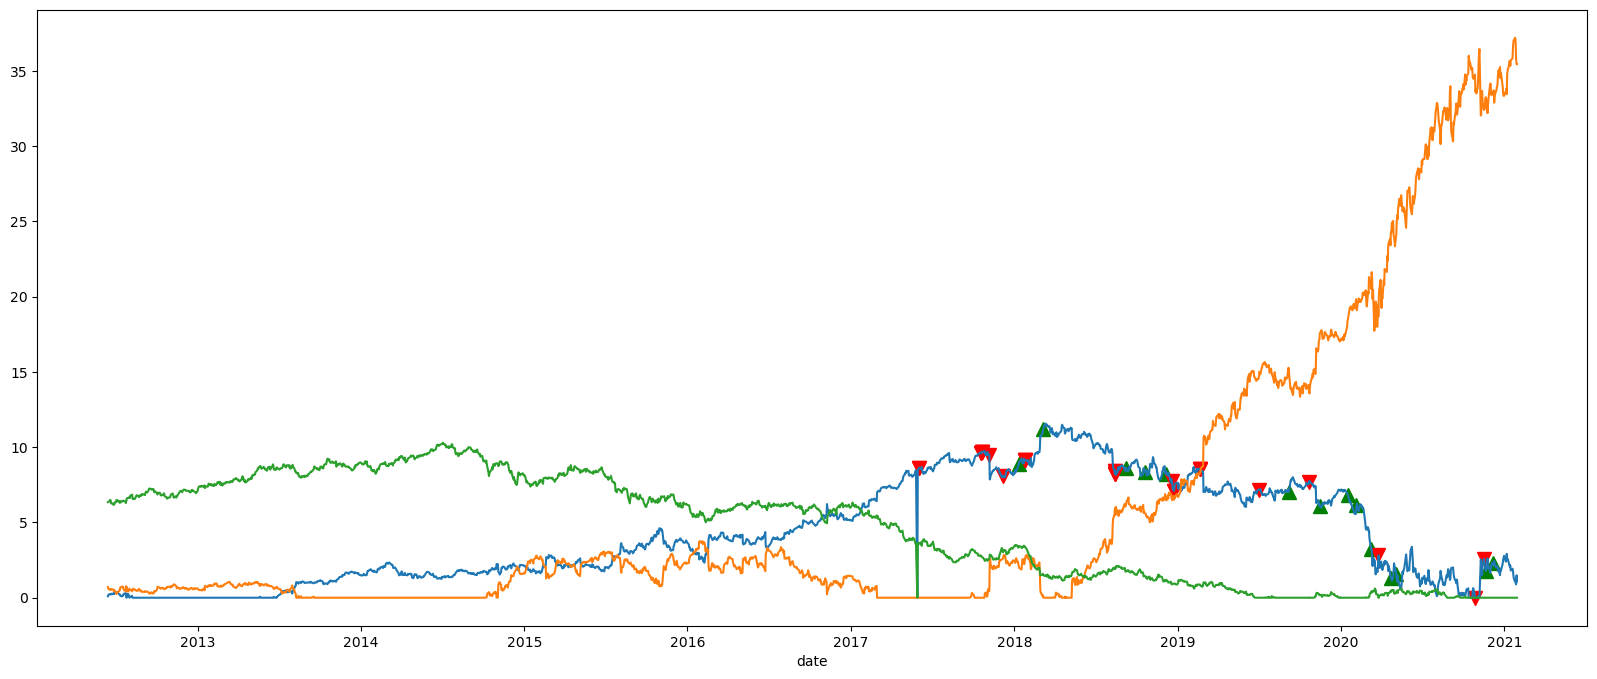

In [77]:
#  with 3 components
plt.plot(senator[senator['type'] == 'buy'].index,
         df_W_sen.loc[senator[senator['type'] == 'buy'].index,:]['C1'],  
         '^', markersize=10, color='g')
plt.plot(senator[senator['type'] == 'sell'].index,
         df_W_sen.loc[senator[senator['type'] == 'sell'].index,:]['C1'], 
         'v', markersize=10, color='r')
df_W_sen['C1'].plot(figsize=(20,8))
df_W_sen['C2'].plot(figsize=(20,8))
df_W_sen['C3'].plot(figsize=(20,8))

### Correlation with market movement

In [78]:
df

symbol             AA        AAL        AAN       AAON        AAPL        AAT  \
date                                                                            
2012-06-14  19.515673  11.765413        NaN   7.983615   17.399382  17.083687   
2012-06-15  19.899221  11.341181        NaN   8.265535   17.478525  17.068899   
2012-06-18  19.605921  11.784270        NaN   8.106191   17.833197  17.305555   
2012-06-19  20.079712  11.972816        NaN   8.179735   17.882812  17.446070   
2012-06-20  20.124834  12.283922        NaN   8.093934   17.831972  17.327742   
...               ...        ...        ...        ...         ...        ...   
2021-01-25  19.156027  15.430000  20.153290  72.436684  141.224701  26.598875   
2021-01-26  18.383448  15.530000  18.638659  72.861610  141.461853  26.673254   
2021-01-27  18.482494  16.559999  17.374859  74.699699  140.374893  26.143322   
2021-01-28  18.324018  18.100000  16.844255  73.158073  135.463852  26.496609   
2021-01-29  17.828773  17.170000  16.342594  73.128433  130.394714  25.687765   

symbol            ABB        ABBV         ABT        ACA  ...         WW  \
date                                                      ...              
2012-06-14  11.334121         NaN   24.302471        NaN  ...  52.989735   
2012-06-15  11.291777         NaN   24.443264        NaN  ...  51.680386   
2012-06-18  11.334121         NaN   24.521486        NaN  ...  52.120094   
2012-06-19  11.630529         NaN   24.587969        NaN  ...  53.800755   
2012-06-20  11.644645         NaN   24.568417        NaN  ...  52.188492   
...               ...         ...         ...        ...  ...        ...   
2021-01-25  28.507675  102.675377  111.556915  60.989021  ...  24.969999   
2021-01-26  28.915064  101.095757  111.566650  59.896206  ...  24.799999   
2021-01-27  28.251875   95.511330  111.138771  56.945602  ...  24.870001   
2021-01-28  28.564520   96.830765  117.070580  57.064816  ...  26.639999   
2021-01-29  27.958176   95.223274  120.182343  55.425591  ...  26.559999   

symbol             WY        XEL        XOM        XPO         YUM       YUMC  \
date                                                                            
2012-06-14  13.968704  20.417643  53.095421   6.201161   37.871746        NaN   
2012-06-15  14.111239  20.502865  53.800098   6.374088   38.206852        NaN   
2012-06-18  14.219835  20.609400  53.728985   6.526264   38.683033        NaN   
2012-06-19  14.464190  20.537704  54.614655   6.578142   39.535480        NaN   
2012-06-20  14.416678  20.179281  54.931431   6.221912   38.935833        NaN   
...               ...        ...        ...        ...         ...        ...   
2021-01-25  30.672638  63.359425  42.497265  41.329548  101.572311  57.322258   
2021-01-26  30.343018  62.702007  41.563953  41.153160  102.614464  58.274841   
2021-01-27  29.482355  60.805992  41.092762  39.271713   98.445816  57.027645   
2021-01-28  30.233149  60.634487  41.736115  39.659073   98.937958  55.996494   
2021-01-29  28.557600  60.967968  40.630646  38.185734   97.934387  55.692047   

symbol             ZBH          ZM         ZTS  
date                                            
2012-06-14   53.887081         NaN         NaN  
2012-06-15   56.171253         NaN         NaN  
2012-06-18   55.771301         NaN         NaN  
2012-06-19   56.260132         NaN         NaN  
2012-06-20   56.055714         NaN         NaN  
...                ...         ...         ...  
2021-01-25  152.691071  391.829987  159.534058  
2021-01-26  151.646347  374.390015  157.922302  
2021-01-27  146.259857  370.739990  151.435715  
2021-01-28  150.505798  378.589996  154.777908  
2021-01-29  147.285385  372.070007  152.523422  

[2172 rows x 634 columns]

In [79]:
df.index = pd.to_datetime(df.index)

In [80]:
senate_melted = senate[senate['ticker'] != '--']

senate_melted = senate_melted[['senator', 'ticker', 'type']]

In [81]:
dates = pd.Series(senate_melted.index)

In [82]:
senate_melted = senate_melted.reset_index()

In [83]:
# time_change = pd.DataFrame()

senate_melted['one_mos'] = dates.apply(lambda x: pd.date_range(x, periods=1, freq="BM")[0])
senate_melted['two_mos'] = dates.apply(lambda x: pd.date_range(x, periods=2, freq="BM")[1])
senate_melted['three_mos'] = dates.apply(lambda x: pd.date_range(x, periods=3, freq="BM")[2])
senate_melted['one_yr'] = dates.apply(lambda x: pd.date_range(x, periods=1, freq="BY")[0])

In [84]:
senate_melted = senate_melted.rename(columns={"trade_date": "date"})

In [85]:
df_melted = pd.melt(df.reset_index(), id_vars='date').set_index('date')

df_melted  = df_melted.reset_index()

df_melted = df_melted.sort_values(by=['date'], ignore_index=True)

df_melted = df_melted.rename(columns={"symbol": "ticker"})

df_melted

date ticker       value
0       2012-06-14     AA   19.515673
1       2012-06-14   CTSH   27.519220
2       2012-06-14    TWO   19.058399
3       2012-06-14   CTBI   20.971254
4       2012-06-14    CSX    6.073809
...            ...    ...         ...
1377043 2021-01-29    OLN   23.139860
1377044 2021-01-29    OKE   35.626900
1377045 2021-01-29    OHI   30.623632
1377046 2021-01-29    OSK   89.070183
1377047 2021-01-29    ZTS  152.523422

[1377048 rows x 3 columns]

In [86]:
senate_melted = pd.merge_asof(senate_melted, 
                              df_melted, 
                              on='date', by='ticker', direction="forward").rename(columns={'value':'current'})

In [87]:
senate_melted

date         senator ticker  type    one_mos    two_mos  three_mos  \
0    2012-09-13   Thomas Carper     DD   buy 2012-09-28 2012-10-31 2012-11-30   
1    2012-12-17   Thomas Carper     DD   buy 2012-12-31 2013-01-31 2013-02-28   
2    2013-03-15   Thomas Carper     DD   buy 2013-03-29 2013-04-30 2013-05-31   
3    2013-04-29     John Hoeven     CG   buy 2013-04-30 2013-05-31 2013-06-28   
4    2013-05-01     John Hoeven    KMP   buy 2013-05-31 2013-06-28 2013-07-31   
...         ...             ...    ...   ...        ...        ...        ...   
6170 2021-01-27  Patrick Toomey   SHOP  sell 2021-01-29 2021-02-26 2021-03-31   
6171 2021-01-27     Jerry Moran   COST  sell 2021-01-29 2021-02-26 2021-03-31   
6172 2021-01-27     Jerry Moran   COST  sell 2021-01-29 2021-02-26 2021-03-31   
6173 2021-01-28  Patrick Toomey    GME  sell 2021-01-29 2021-02-26 2021-03-31   
6174 2021-01-29   Thomas Carper  XCAPX   buy 2021-01-29 2021-02-26 2021-03-31   

         one_yr     current  
0    2012-12-31   33.666405  
1    2012-12-31   34.454262  
2    2013-12-31   36.973824  
3    2013-12-31   17.446537  
4    2013-12-31         NaN  
...         ...         ...  
6170 2021-12-31  109.208000  
6171 2021-12-31  351.340485  
6172 2021-12-31  351.340485  
6173 2021-12-31   48.400002  
6174 2021-12-31         NaN  

[6175 rows x 9 columns]

In [88]:
senate_melted = pd.merge_asof(senate_melted, 
              df_melted, 
              left_on='one_mos', right_on='date', 
              by='ticker', direction="forward").rename(columns={'value':'one_mos_price'}).drop(columns='date_y')

senate_melted = pd.merge_asof(senate_melted, 
              df_melted, 
              left_on='two_mos', right_on='date', 
              by='ticker', direction="forward").rename(columns={'value':'two_mos_price'}).drop(columns='date')

senate_melted = pd.merge_asof(senate_melted, 
              df_melted, 
              left_on='three_mos', right_on='date', 
              by='ticker', direction="forward").rename(columns={'value':'three_mos_price'}).drop(columns='date')

senate_melted = pd.merge_asof(senate_melted, 
              df_melted, 
              left_on='one_yr', right_on='date', 
              by='ticker', direction="forward").rename(columns={'value':'one_yr_price'}).drop(columns='date')

In [89]:
senate_melted = senate_melted.drop(columns=['one_mos', 
                                            'two_mos', 
                                            'three_mos', 
                                            'one_yr']).rename(columns={'date_x':'date'})

In [90]:
senate_melted = senate_melted.dropna()

In [91]:
senate_melted

date         senator ticker type     current  one_mos_price  \
0    2012-09-13   Thomas Carper     DD  buy   33.666405      31.357481   
1    2012-12-17   Thomas Carper     DD  buy   34.454262      35.355350   
2    2013-03-15   Thomas Carper     DD  buy   36.973824      34.648884   
3    2013-04-29     John Hoeven     CG  buy   17.446537      18.035126   
5    2013-06-13   Thomas Carper     DD  buy   38.271725      35.885834   
...         ...             ...    ...  ...         ...            ...   
6091 2020-11-20   Thomas Carper   NTLA  buy   32.340000      39.270000   
6092 2020-11-20   Thomas Carper   FTNT  buy   23.624001      24.646000   
6093 2020-11-20   Thomas Carper   ATVI  buy   75.988197      78.629639   
6095 2020-11-24     Pat Roberts   COST  buy  369.107819     376.360809   
6096 2020-11-30  Patrick Toomey    AIV  buy    4.037315       4.037315   

      two_mos_price  three_mos_price  one_yr_price  
0         31.725630        32.689320     35.355350  
1         35.213184        34.688259     35.355350  
2         37.454369        38.061844     50.288040  
3         16.277668        14.307154     20.107870  
5         39.087341        41.719929     50.288040  
...             ...              ...           ...  
6091      54.400002        62.619999     54.400002  
6092      29.705999        28.950001     29.705999  
6093      91.856590        90.026382     91.856590  
6095     371.441528       347.436554    371.441528  
6096       5.268547         4.580044      5.268547  

[4600 rows x 9 columns]

In [92]:
senate_melted['one_mos_ret'] = (senate_melted['one_mos_price'] / senate_melted['current']) - 1
senate_melted['two_mos_ret'] = (senate_melted['two_mos_price'] / senate_melted['current']) - 1
senate_melted['three_mos_ret'] = (senate_melted['three_mos_price'] / senate_melted['current']) - 1 
senate_melted['one_yr_ret'] = (senate_melted['one_yr_price'] / senate_melted['current']) - 1

In [93]:
senate_melted = senate_melted.drop(columns=['one_mos_price', 'two_mos_price', 'three_mos_price', 'one_yr_price'])

In [94]:
senate_melted

date         senator ticker type     current  one_mos_ret  \
0    2012-09-13   Thomas Carper     DD  buy   33.666405    -0.068582   
1    2012-12-17   Thomas Carper     DD  buy   34.454262     0.026153   
2    2013-03-15   Thomas Carper     DD  buy   36.973824    -0.062881   
3    2013-04-29     John Hoeven     CG  buy   17.446537     0.033737   
5    2013-06-13   Thomas Carper     DD  buy   38.271725    -0.062341   
...         ...             ...    ...  ...         ...          ...   
6091 2020-11-20   Thomas Carper   NTLA  buy   32.340000     0.214286   
6092 2020-11-20   Thomas Carper   FTNT  buy   23.624001     0.043261   
6093 2020-11-20   Thomas Carper   ATVI  buy   75.988197     0.034761   
6095 2020-11-24     Pat Roberts   COST  buy  369.107819     0.019650   
6096 2020-11-30  Patrick Toomey    AIV  buy    4.037315     0.000000   

      two_mos_ret  three_mos_ret  one_yr_ret  
0       -0.057647      -0.029023    0.050167  
1        0.022027       0.006792    0.026153  
2        0.012997       0.029427    0.360098  
3       -0.066997      -0.179943    0.152542  
5        0.021311       0.090098    0.313974  
...           ...            ...         ...  
6091     0.682127       0.936302    0.682127  
6092     0.257450       0.225449    0.257450  
6093     0.208827       0.184742    0.208827  
6095     0.006323      -0.058713    0.006323  
6096     0.304963       0.134428    0.304963  

[4600 rows x 9 columns]

In [95]:
senate_melted.groupby('senator')

<AxesSubplot:ylabel='Frequency'>

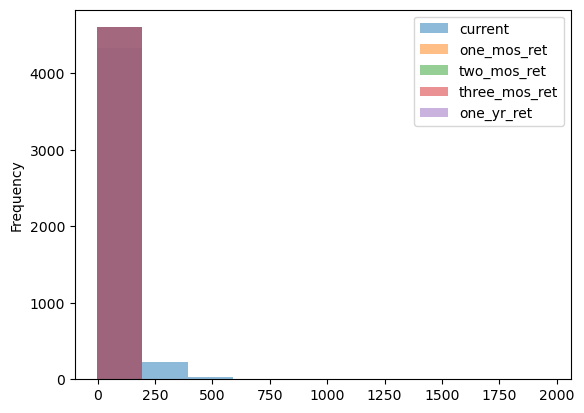

In [96]:
senate_melted.plot.hist(alpha=0.5)

In [97]:
grouped = senate_melted.groupby('senator')

In [98]:
senate_melted['senator'].unique()

array(['Thomas Carper', 'John Hoeven', 'Susan Collins',
       'Sheldon Whitehouse', 'Rafael Cruz', 'John Reed', 'Pat Roberts',
       'Cory Booker', 'Patrick Toomey', 'Maria Cantwell', 'Roy Blunt',
       'Benjamin Cardin', 'Timothy Kaine', 'David Perdue', 'Gary Peters',
       'Thomas Tillis', 'James Inhofe', 'William Cassidy',
       'Shelley Capito', 'John Cornyn', 'Michael Enzi', 'Chris VanHollen',
       'Patty Murray', 'Joseph ManchinIii', 'Tammy Duckworth',
       'Robert Casey', 'A. MitchellMcconnell', 'Mark Warner',
       'Tina Smith', 'Christopher Coons', 'Daniel Sullivan',
       'Roger Wicker', 'Jerry Moran', 'Thomas Udall', 'Jacklyn Rosen',
       'Kelly Loeffler', 'Richard Burr', 'Diane Feinstein', 'Ron Wyden'],
      dtype=object)

<AxesSubplot:ylabel='Frequency'>

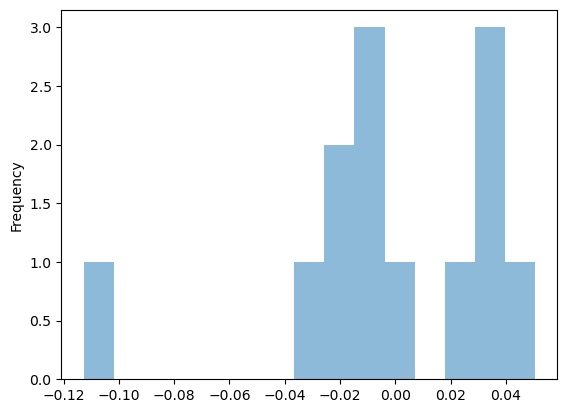

In [99]:
grouped.get_group('Tammy Duckworth')['one_mos_ret'].plot.hist(bins=15, alpha=0.5)

<AxesSubplot:ylabel='Frequency'>

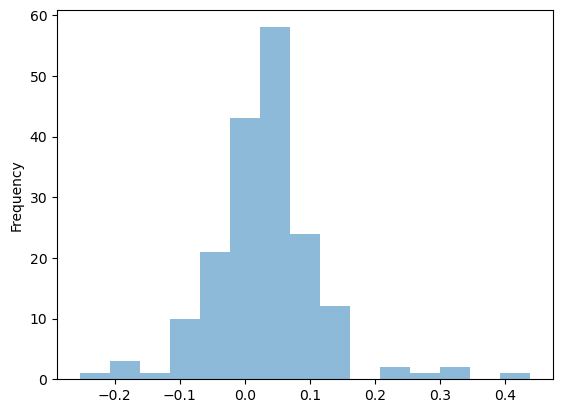

In [100]:
grouped.get_group('Ron Wyden')['one_mos_ret'].plot.hist(bins=15, alpha=0.5)

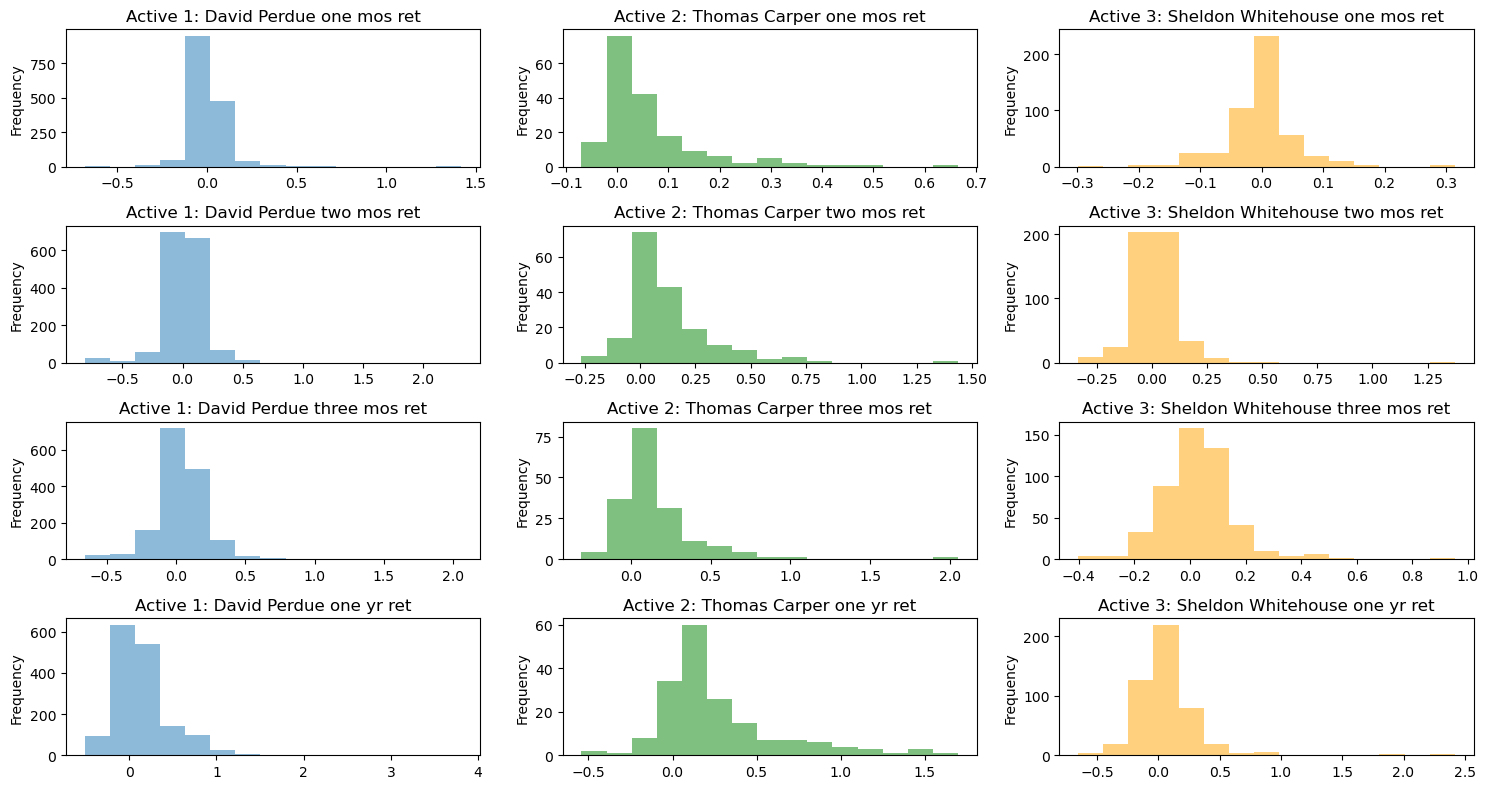

In [101]:
plt.figure(figsize=(15,8))
plt.subplot(4, 3, 1)

grouped.get_group(active[0])['one_mos_ret'].plot.hist(bins=15, alpha=0.5)
plt.title('Active 1: ' + active[0] + ' one mos ret')

plt.subplot(4, 3, 2)

grouped.get_group(active[1])['one_mos_ret'].plot.hist(bins=15, alpha=0.5, color='green')
plt.title('Active 2: ' + active[1] + ' one mos ret')

plt.subplot(4, 3, 3)

grouped.get_group(active[2])['one_mos_ret'].plot.hist(bins=15, alpha=0.5, color='orange')
plt.title('Active 3: ' + active[2] + ' one mos ret')

plt.subplot(4, 3, 4)

grouped.get_group(active[0])['two_mos_ret'].plot.hist(bins=15, alpha=0.5)
plt.title('Active 1: ' + active[0] + ' two mos ret')

plt.subplot(4, 3, 5)

grouped.get_group(active[1])['two_mos_ret'].plot.hist(bins=15, alpha=0.5, color='green')
plt.title('Active 2: ' + active[1] + ' two mos ret')

plt.subplot(4, 3, 6)

grouped.get_group(active[2])['two_mos_ret'].plot.hist(bins=15, alpha=0.5, color='orange')
plt.title('Active 3: ' + active[2]+ ' two mos ret')

plt.subplot(4, 3, 7)

grouped.get_group(active[0])['three_mos_ret'].plot.hist(bins=15, alpha=0.5)
plt.title('Active 1: ' + active[0] + ' three mos ret')

plt.subplot(4, 3, 8)

grouped.get_group(active[1])['three_mos_ret'].plot.hist(bins=15, alpha=0.5, color='green')
plt.title('Active 2: ' + active[1] + ' three mos ret')

plt.subplot(4, 3, 9)

grouped.get_group(active[2])['three_mos_ret'].plot.hist(bins=15, alpha=0.5, color='orange')
plt.title('Active 3: ' + active[2]+ ' three mos ret')

plt.subplot(4, 3, 10)

grouped.get_group(active[0])['one_yr_ret'].plot.hist(bins=15, alpha=0.5)
plt.title('Active 1: ' + active[0] + ' one yr ret')

plt.subplot(4, 3, 11)

grouped.get_group(active[1])['one_yr_ret'].plot.hist(bins=15, alpha=0.5, color='green')
plt.title('Active 2: ' + active[1] + ' one yr ret')
    
plt.subplot(4, 3, 12)

grouped.get_group(active[2])['one_yr_ret'].plot.hist(bins=15, alpha=0.5, color='orange')
plt.title('Active 3: ' + active[2]+ ' one yr ret')

plt.tight_layout()

In [102]:
# according to the data 2018
wealthiest = ['John Hoeven', 'Mark Warner']

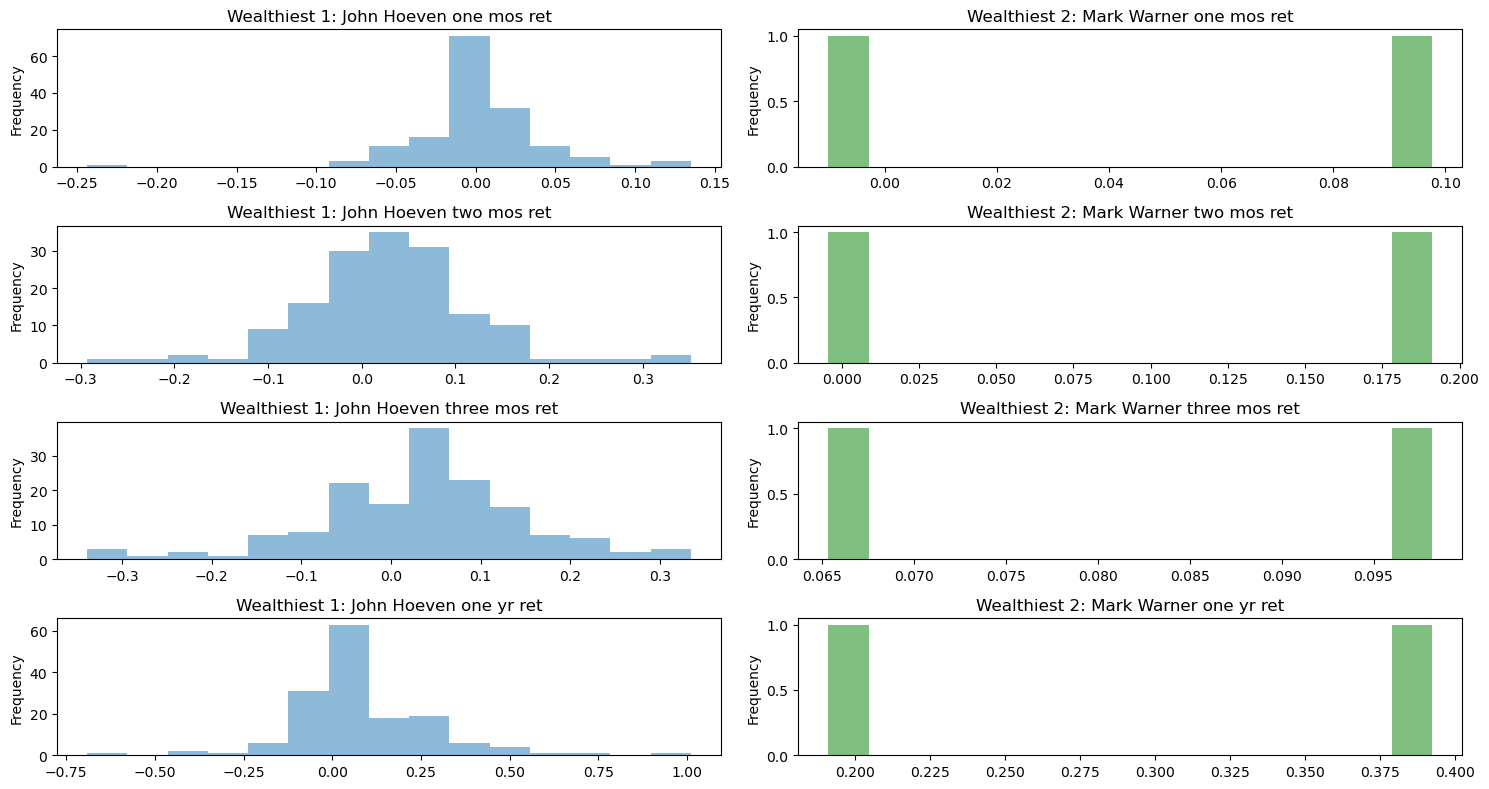

In [103]:
plt.figure(figsize=(15,8))
plt.subplot(4, 2, 1)

grouped.get_group(wealthiest[0])['one_mos_ret'].plot.hist(bins=15, alpha=0.5)
plt.title('Wealthiest 1: ' + wealthiest[0] + ' one mos ret')

plt.subplot(4, 2, 2)

grouped.get_group(wealthiest[1])['one_mos_ret'].plot.hist(bins=15, alpha=0.5, color='green')
plt.title('Wealthiest 2: ' + wealthiest[1] + ' one mos ret')

plt.subplot(4, 2, 3)

grouped.get_group(wealthiest[0])['two_mos_ret'].plot.hist(bins=15, alpha=0.5)
plt.title('Wealthiest 1: ' + wealthiest[0] + ' two mos ret')

plt.subplot(4, 2, 4)

grouped.get_group(wealthiest[1])['two_mos_ret'].plot.hist(bins=15, alpha=0.5, color='green')
plt.title('Wealthiest 2: ' + wealthiest[1] + ' two mos ret')

plt.subplot(4, 2, 5)

grouped.get_group(wealthiest[0])['three_mos_ret'].plot.hist(bins=15, alpha=0.5)
plt.title('Wealthiest 1: ' + wealthiest[0] + ' three mos ret')

plt.subplot(4, 2, 6)

grouped.get_group(wealthiest[1])['three_mos_ret'].plot.hist(bins=15, alpha=0.5, color='green')
plt.title('Wealthiest 2: ' + wealthiest[1]+ ' three mos ret')

plt.subplot(4, 2, 7)

grouped.get_group(wealthiest[0])['one_yr_ret'].plot.hist(bins=15, alpha=0.5)
plt.title('Wealthiest 1: ' + wealthiest[0] + ' one yr ret')

plt.subplot(4, 2, 8)

grouped.get_group(wealthiest[1])['one_yr_ret'].plot.hist(bins=15, alpha=0.5, color='green')
plt.title('Wealthiest 2: ' + wealthiest[1] + ' one yr ret')


plt.tight_layout()

NMF for the PCA comparison

In [3]:
senate_pca_comp = pd.read_csv('Data for Finance Final Project - Copy of Senator Portfolio Time Series.csv', index_col=0)

In [4]:
senate_pca_comp.head()

Roy Blunt  Susan Collins  John Hoeven  Cory Booker  Mark Warner  \
2012-06-14  2852255.0      2062021.5   23344784.5     403751.5  107046287.5   
2012-06-15  2852255.0      2062021.5   23344784.5     403751.5  107046287.5   
2012-06-16  2852255.0      2062021.5   23344784.5     403751.5  107046287.5   
2012-06-17  2852255.0      2062021.5   23344784.5     403751.5  107046287.5   
2012-06-18  2852255.0      2062021.5   23344784.5     403751.5  107046287.5   

            Mark Warner.1  John Cornyn  Maria Cantwell  Tina Smith  \
2012-06-14     17068767.0     942261.0       2878254.0    848010.0   
2012-06-15     17068767.0     942261.0       2878254.0    848010.0   
2012-06-16     17068767.0     942261.0       2878254.0    848010.0   
2012-06-17     17068767.0     942261.0       2878254.0    848010.0   
2012-06-18     17068767.0     942261.0       2878254.0    848010.0   

            Tammy Duckworth  Michael Bennet  Sheldon Whitehouse  Gary Peters  \
2012-06-14         348765.5         7853007           3721814.0    2184052.5   
2012-06-15         348765.5         7853007           3721814.0    2184052.5   
2012-06-16         348765.5         7853007           3721814.0    2184052.5   
2012-06-17         348765.5         7853007           3721814.0    2184052.5   
2012-06-18         348765.5         7853007           3721814.0    2184052.5   

            Jerry Moran  David Perdue  Richard Burr  Patty Murray  Ron Wyden  \
2012-06-14     879769.5    12911298.0     3713106.5      843505.0  3438512.5   
2012-06-15     879769.5    12911298.0     3713106.5      843505.0  3438512.5   
2012-06-16     879769.5    12911298.0     3713106.5      843505.0  3438512.5   
2012-06-17     879769.5    12911298.0     3713106.5      843505.0  3438512.5   
2012-06-18     879769.5    12911298.0     3713106.5      843505.0  3438512.5   

            Pat Roberts  
2012-06-14    1483257.0  
2012-06-15    1483257.0  
2012-06-16    1483257.0  
2012-06-17    1483257.0  
2012-06-18    1483257.0

In [10]:
res = []
for i in senate_pca_comp.columns:
    res.append(min(senate_pca_comp[i]))

In [11]:
min(res) # add to shift the data while preserving the pattern for NMF

-1309826783.0

In [13]:
abs(min(res))

1309826783.0

In [24]:
model_sen_comp = NMF(n_components=3, init='random', beta_loss='frobenius', random_state=0, max_iter=10000)
W_sen_comp = model_sen_comp.fit_transform(senate_pca_comp.fillna(0).values + abs(min(res)))
H_sen_comp = model_sen_comp.components_

In [25]:
model_sen_comp_6 = NMF(n_components=6, init='random', beta_loss='frobenius', random_state=0, max_iter=10000)
W_sen_comp_6 = model_sen_comp_6.fit_transform(senate_pca_comp.fillna(0).values + abs(min(res)))
H_sen_comp_6 = model_sen_comp_6.components_

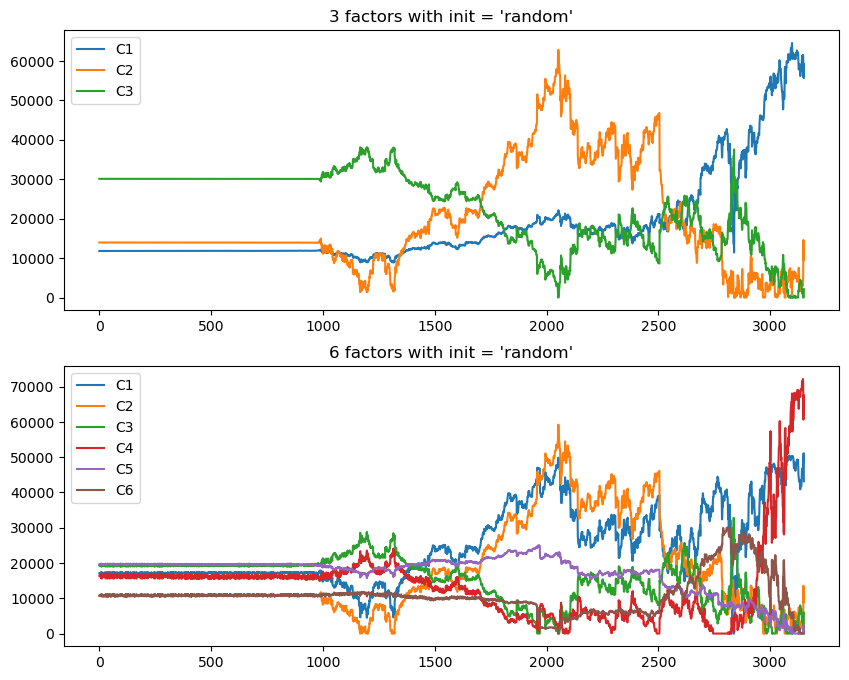

In [26]:
plt.figure(figsize=(10,8))
plt.subplot(2, 1, 1)

plt.title("3 factors with init = 'random'")
plt.plot(W_sen_comp[:,0], label='C1')
plt.plot(W_sen_comp[:,1], label='C2')
plt.plot(W_sen_comp[:,2], label='C3')
plt.legend()

plt.subplot(2, 1, 2)

plt.title("6 factors with init = 'random'")
plt.plot(W_sen_comp_6[:,0], label='C1')
plt.plot(W_sen_comp_6[:,1], label='C2')
plt.plot(W_sen_comp_6[:,2], label='C3')
plt.plot(W_sen_comp_6[:,3], label='C4')
plt.plot(W_sen_comp_6[:,4], label='C5')
plt.plot(W_sen_comp_6[:,5], label='C6')

plt.legend()